In [1]:
import numpy as np
from scipy import optimize, special
import itertools
from tqdm import trange
from scipy.special import expit
import matplotlib.pyplot as plt

## Initialize weights for theta values

In [14]:
def rand_initialize_weights(layer_in, layer_out):
    # gaussian is strong
    # uniform is stronger
    ret = np.random.uniform(-1., 1., size=(layer_out,layer_in + 1))/np.sqrt(layer_out * layer_in)
    return ret.astype(np.float32)

In [3]:
data = np.genfromtxt('./data/tt.csv', delimiter=',')
y = data[:,0].reshape(-1,1)  # Shape: (688,1)
X = data[:, 1:] / 255              # Shape: (m, input_layer_size)
m = len(y)

examples: 688
theta1 shape: (120, 785), theta2 shape: (26, 121)


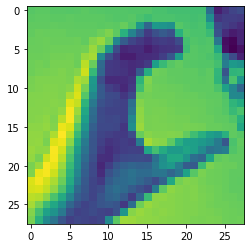

In [15]:
# Load data
# data = np.genfromtxt('./data/sign_mnist_train.csv', delimiter=',')
# y = data[:,0].reshape(-1,1)  # Shape: (688,1)
# X = data[:, 1:] / 255              # Shape: (m, input_layer_size)
# m = len(y)
print(f'examples: {m}')

input_layer_size = 784
hidden_layer_size = 120      # hidden layer has 120 nodes excluding bias 
num_labels = 26              # 26 total output values: a=0, b=1, ... , z=25

# Initialize theta values
# theta1 size = (input_layer_size + 1, hidden_layer_size)
# theta2 size = (hidden_layer_size + 1, num_labels)
np.random.seed(1999)
theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

print(f'theta1 shape: {np.shape(theta1)}, theta2 shape: {np.shape(theta2)}')

# supposed to be: : theta1 shape (120, 785), theta2 shape: (26, 121)
plt.imshow(X[2].reshape(28,28))

## Sigmoid function and derivative
* Used for activation function in forward propogation
* Derivative used for back propogation

In [5]:
def sigmoid(z):
   # return (1 / (1 + np.exp(-z)))
    s = expit(z)
    return s

def dx_sigmoid(z):
    res = sigmoid(z)
    return (res * (1 - res))

print(sigmoid(0))
print(dx_sigmoid(0))

0.5
0.25


In [6]:
def return_labeled(y, num_labels):
    '''returns (m,num_labels) matrix where each column corresoponds to an example
    all indexes are 0, each column contains a single 1, the row corresponding to the answer'''
    m = np.size(y)
    out = np.zeros((m, num_labels))
    for row in range(0, m):
        label = int(y[row])
        out[row, label] = 1
    return out

In [7]:
def forward_backward(X,y):
    y_k = return_labeled(y, num_labels) # output matrix used for cost evaluation
    m = len(y)
    # Forward propogation
    a1 = np.c_[np.ones((m,1)), X]   # layer 1 : adding a bias column of 1's to X. (m, input_size + 1)
    z2 = a1.dot(theta1.T)           # layer 2 matrix calculation
    a2 = sigmoid(z2)                # activation of layer 2: shape(m, hidden_layer_size)
    a2 = np.c_[np.ones((m, 1)), a2] # adding a bias column of 1's : shape(m, hidden_layer_size + 1)
    z3 = a2.dot(theta2.T)           # layer3 || output layer calculation
    a3 = sigmoid(z3)                # activation of output layer: size = (m, num_labels)
    
    # Cost function
    inner_term0 = (-y_k * np.log(a3))
    inner_term1 = (1 - y_k) * np.log(1 - a3)
    left_side = np.sum(inner_term0 - inner_term1) / m
    right_side = np.sum(theta1[:, 1:] ** 2) + np.sum(theta2[:,1:] ** 2) # sum of all theta vals squred excluding theta index0 
    right_side = (lam / 2 / m) * right_side
    cost = left_side + right_side
    
    # Back propogation
#     print(f'shape of a3: {np.shape(a3)}')
#     print(f'shape of y_k: {np.shape(y_k)}')
    print(a3)
    delta3 = a3 - y_k
    delta2 = delta3.dot(theta2)[:,1:] * dx_sigmoid(z2) # excluding bias
    Gradient1 = (delta2.T).dot(a1)
    Gradient2 = (delta3.T).dot(a2)
    
#     print(f'Gradient 1: {Gradient1}')
#     print(f'Gradient 2: {Gradient2}')

    
    return cost, a3, Gradient1, Gradient2

In [8]:
def check_same(ar):
    for i in range(0, len(ar) - 1):
        if(ar[i] != ar[i + 1]):
            return False
    return True

In [13]:

learning_rate = 0.0001
batch_size = 40
lam = 2.5 # Lambda used for regularization in cost function


# reinitialize thetas
theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

losses, accuracies = [], []
samp = np.random.randint(0, X.shape[0], size=(batch_size))
X_train = X[samp]
y_train = y[samp]
J, h_x, grad1, grad2 = forward_backward(X_train, y_train)


prediction = np.argmax(h_x, axis=1)

if(check_same(prediction)):
    print('rats')
else:
    print('im so happy')

print(prediction)
xi = np.argmax(h_x, axis=0)
print(np.shape(prediction))
print(np.shape(xi))

[[0.50950356 0.51501518 0.47593525 ... 0.50454888 0.49093125 0.50636233]
 [0.5094905  0.51504636 0.47589373 ... 0.50453575 0.4910308  0.50643268]
 [0.5095413  0.51498973 0.47595636 ... 0.50454132 0.49098482 0.5064939 ]
 ...
 [0.50959752 0.51498351 0.47584723 ... 0.50448207 0.49098047 0.50651573]
 [0.50953366 0.51517582 0.47600034 ... 0.50450733 0.49107216 0.50646702]
 [0.50955807 0.51490358 0.47590745 ... 0.50452401 0.49089121 0.50650077]]
rats
[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
(40,)
(26,)


In [10]:
# # Model training

# for i in (t := trange(1000)):
#     samp = np.random.randint(0, X.shape[0], size=(batch_size))
#     X_train = X[samp]
#     y_train = y[samp]
#     J, h_x, grad1, grad2 = forward_backward(X_train, y_train)
    
#     prediction = np.argmax(h_x, axis=1)
# #     if(check_same(prediction)):
# #         print("all the same")
#     accuracy = (prediction == y).mean()
    
#     # Gradient descent:
#     theta1 = theta1 - (learning_rate * grad1)
#     theta2 = theta2 - (learning_rate * grad2)
    
#     loss = J.mean()
#     losses.append(loss)
    
#     accuracies.append(accuracy)
#     t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
